In [1]:
import ta
import trendet
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import sys
sys.path.append('/Users/jp/Desktop/Investment/utils')
import utils as utils
import math
from string import ascii_uppercase
from itertools import product
import os
from binance.client import Client
from binance.exceptions import *
import requests as requests
import time as time
import matplotlib.dates as mdates

In [2]:
class Macd_ls_backtester_sma_sltp_lev():
    '''
    Macd class for backtesting strategies
    How to use this class:
    1) Use 'prepare_data' method:
        INPUTS
        - start
        - end
        - interval
        
        COLUMNS CREATED
        - log_returns_hold
        - multiple_hold_acum
        - position
        - macd_inv_sign
    '''
    
    def __init__(self, symbol=None, interval=None, trading_cost_fees=None, trading_cost_others=None):
        
        """Macd long backtester constructor
        :param symbol: symbol from Binance from which to extract the data, .i.e. 'BTCUSDT'
        :type symbol: str.
        :param data: a dataframe with all the data extract from the Binance API for the selected function inputs.
        :type data: DataFrame
        :param data_uptrend: a dataframe with data extracted from self.data but only for the type of trend
        :type data_uptrend: str.
        :param data_downtrend: a dataframe with data extracted from self.data but only for the type of trend
        :type data_down_trend: str.
        :param data_sideways: a dataframe with data extracted from self.data but only for the type of trend
        :type data_sideways: str.
        """
        print('class version 0.0 is being used')
        self.symbol = symbol
        self.data_init = pd.DataFrame()
        self.start = None
        self.end = None
        self.interval = interval
        self.from_time = None
        self.to_time = None
        self.ema_slow = None
        self.ema_fast = None
        self.ema_signal = None
        self.sma_slow = None
        self.sma_fast = None
        self.opt_results = None
        self.opt_ini_time_str = None
        self.opt_minutes_elapsed = None
        self.opt_max = None
        self.opt_max_net = None
        self.sltp_dates = []
        self.trading_cost_fees = trading_cost_fees #fees
        self.trading_cost_others = trading_cost_others #slippage, bid ask/spread (if high liquidity might be close to 0$)
        
        
    def __repr__(self):
        return f"Macd_long_backtester(symbol={self.symbol}, interval={self.interval}, trading_cost_fees={self.trading_cost_fees}, trading_cost_others={self.trading_cost_others})"

    def prepare_data(self, start=None, end=None):
        '''
        REMARK: Introduced time must be in Tokyo time (UTC+9) but the calculations will be in UTC
        Prepare all the fields of data necessary for the study. The interval of dates to be studied is the one
        given when delclaring the class. To prepare another interval of dates, please create another class instance.
        :param start: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-01-29-20:00"
        :type start: str.
        :param end: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-02-29-20:00"
        :type end: str.
        :param interval: string among the followings: ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        :type interval: str.
        '''
        
        self.start = start
        self.end = end
        from_time = int(datetime.strptime(start, "%Y-%m-%d-%H:%M").timestamp()*1000)
        to_time = int(datetime.strptime(end, "%Y-%m-%d-%H:%M").timestamp()*1000)
        self.from_time = from_time
        self.to_time = to_time
        self.data_init = utils.get_history_v2(symbol=self.symbol, interval=self.interval, start=from_time, end=to_time)[0]
        self.data_init['log_returns_hold'] = np.log(self.data_init.Close.div(self.data_init.Close.shift(1)))
        self.data_init['multiple_hold_acum'] = np.exp(self.data_init.log_returns_hold.cumsum())
        #initialize positions and sign_inv
        self.data_init['position'] = 0
        self.data_init['macd_inv_sign'] = 0
        
    def add_sessions(self, visualize = False): # NEW!!!
        ''' 
        Adds/Labels Trading Sessions and their compound returns.
        '''
            
        data = self.data_init.copy()
        data["ses"] = np.sign(data.trades).cumsum().shift().fillna(0)
        data["macd_simplecret_net_ses"] = data.groupby("ses").macd_log_returns_net.cumsum().apply(np.exp) - 1
        self.data_init = data
        if visualize:
            data["macd_simplecret_net_ses"].plot(figsize = (12, 8))
            plt.show()          

    def add_leverage(self, leverage, report = True): # NEW!!!
        ''' 
        Adds Leverage to the Strategy.
        
        Parameter
        ============
        leverage: float (positive)
            degree of leverage.
        
        report: bool, default True
            if True, print Performance Report incl. Leverage.
        '''
        self.add_sessions()
        self.leverage = leverage
        
        data = self.data_init.copy()
        data["macd_simple_ret"] = np.exp(data.macd_log_returns_net) - 1
        data["eff_lev"] = leverage * (1 + data.macd_simplecret_net_ses) / (1 + data.macd_simplecret_net_ses * leverage)
        data.eff_lev.fillna(leverage, inplace = True)
#         data.loc[data.trades !=0, "eff_lev"] = leverage
        levered_returns = data.eff_lev.shift() * data.macd_simple_ret
        levered_returns = np.where(levered_returns < -1, -1, levered_returns)
        data["macd_simple_ret_net_lev"] = levered_returns
        data["macd_simple_ret_net_lev_acum"] = data.macd_simple_ret_net_lev.add(1).cumprod()
        
        self.data_init = data
            
    def execute_backtest(self, start=None, end=None, ema_slow=None, ema_fast=None, ema_signal=None, sma_slow=None, sma_fast=None, sl=None, tp=None):
        '''
        :param start: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-01-29-20:00"
        :type start: str.
        :param end: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-02-29-20:00"
        :type end: str.
        '''
        #Prepare pre-data to start with non NaN at the backtesting period
        from_time_obj = datetime.strptime(start, "%Y-%m-%d-%H:%M")
#       ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        extra_periods = 0
        ema_diff = ema_slow + ema_signal + 2
        
        # Necessary extra periods to have enough data to calculate the strategy parameters at the present moment
        if (ema_diff >= sma_slow):
            extra_periods = ema_diff
        else:
            extra_periods = sma_slow
        
        td = timedelta()
        if 'm' in self.interval:
            num_min = int(self.interval.replace('m',''))
            td = timedelta(minutes=num_min*(extra_periods))
        if 'h' in self.interval:
            num_h = int(self.interval.replace('h',''))
            td = timedelta(hours=num_h*(extra_periods))
        if 'd' in self.interval:
            num_day = int(self.interval.replace('d',''))
            td = timedelta(days=num_day*(extra_periods))
        if 'w' in self.interval:
            num_week = int(self.interval.replace('w',''))
            td = timedelta(weeks=num_week*(extra_periods))
        if 'M' in self.interval:
            num_week_m = int(self.interval.replace('M',''))
            td = timedelta(weeks=num_week_m * 4 * (extra_periods))
            
        pre_from_time_obj = from_time_obj - td
        pre_from_time = int((from_time_obj - td).timestamp()*1000)
        print(pre_from_time_obj)
        
        to_time = int(datetime.strptime(end, "%Y-%m-%d-%H:%M").timestamp()*1000)
        self.to_time = to_time
        
        self.data_init_pre = utils.get_history_v2(symbol=self.symbol, interval=self.interval, start=pre_from_time, end=self.to_time)[0]
        #Assign the MACD parameters to the class to see which parameters have been used last
        self.ema_slow = ema_slow
        self.ema_fast = ema_fast
        self.ema_signal = ema_signal
        #obtaining MACD instance from python ta
        macd_diff = ta.trend.MACD(close=self.data_init_pre.Close, window_slow=ema_slow, window_fast=ema_fast, window_sign=ema_signal, fillna=False).macd_diff()
        macd_macd = ta.trend.MACD(close=self.data_init_pre.Close, window_slow=ema_slow, window_fast=ema_fast, window_sign=ema_signal, fillna=False).macd()
        macd_signal = ta.trend.MACD(close=self.data_init_pre.Close, window_slow=ema_slow, window_fast=ema_fast, window_sign=ema_signal, fillna=False).macd_signal()
        #assigning the values of macd to ticker dataframe
        self.data_init_pre['macd_diff'] = macd_diff
        self.data_init_pre['macd_macd'] = macd_macd
        self.data_init_pre['macd_signal'] = macd_signal         
        #assign SMAs values to class attributes
        self.sma_fast = sma_fast
        self.sma_slow = sma_slow       
        #calculating SMA fast and slow
        sma_fast_ps = ta.trend.SMAIndicator(close=self.data_init_pre.Close, window=self.sma_fast, fillna=False).sma_indicator()
        sma_slow_ps = ta.trend.SMAIndicator(close=self.data_init_pre.Close, window=self.sma_slow, fillna=False).sma_indicator()
        #assigning the smas values to ticker dataframe
        self.data_init_pre['sma_fast_ps'] = sma_fast_ps
        self.data_init_pre['sma_slow_ps'] = sma_slow_ps
        #copy the necessary data from the present moment
        from_time_obj_UTC = from_time_obj - timedelta(hours=9)
        self.data_init = self.data_init_pre.loc[from_time_obj_UTC:].copy()
        #Initialize again buy-and-hold parameters for new data
        self.data_init['log_returns_hold'] = np.log(self.data_init.Close.div(self.data_init.Close.shift(1)))
        self.data_init['multiple_hold_acum'] = np.exp(self.data_init.log_returns_hold.cumsum())
        #initialize again positions and sign_inv for new data
        self.data_init['position'] = 0
        self.data_init['macd_inv_sign'] = 0
        self.data_init['sma_conf'] = 0
        self.data_init['sma_inv_sign'] = 0
        self.data_init['macd_diff_conf'] = 0
        self.data_init['sl_flag'] = None
        self.data_init['tp_flag'] = None
        
        # a sell signal appears when there is a macd_cross downwards and it is confirmed by: sma_fast_ps > sma_slow_ps
        #stablish neutral conditions
        
        # --------------------- MACD CROSS SIGNAL + SMA CONFIRMATION ---------------------
        
        #macd cross short
        ht_macd_diff_pos = self.data_init.macd_diff.shift(1) > 0
        ht_macd_diff_plusone_neg = self.data_init.macd_diff < 0        
       
        #sma short confirmation
        sma_conf_short = self.data_init.sma_fast_ps < self.data_init.sma_slow_ps
        
        #stablish short positions
        self.data_init.loc[ht_macd_diff_pos & ht_macd_diff_plusone_neg, 'macd_inv_sign'] = -1
        self.data_init.loc[sma_conf_short, 'sma_conf'] = -1
        
        #macd cross long
        ht_macd_diff_neg = self.data_init.macd_diff.shift(1) < 0
        ht_macd_diff_plusone_pos = self.data_init.macd_diff > 0
        
        #sma long confirmation
        sma_conf_long = self.data_init.sma_fast_ps > self.data_init.sma_slow_ps        
        
        #stablish buy positions
        self.data_init.loc[ht_macd_diff_neg & ht_macd_diff_plusone_pos, 'macd_inv_sign'] = 1
        self.data_init.loc[sma_conf_long, 'sma_conf'] = 1
        
        # ---------------------------------------------------------------------------------
        
        # --------------------- SMA CROSS SIGNAL + MACD_DIFF CONFIRMATION -----------------
        
        #sma cross short
        ht_sma_pos = self.data_init.sma_fast_ps.shift(1) > self.data_init.sma_slow_ps.shift(1)
        ht_sma_plusone_neg = self.data_init.sma_fast_ps < self.data_init.sma_slow_ps
        
        #macd_diff short confirmation
        macd_diff_conf_short = self.data_init.macd_diff < 0
        
        #stablish short positions
        self.data_init.loc[ht_sma_pos & ht_sma_plusone_neg, 'sma_inv_sign'] = -1
        self.data_init.loc[macd_diff_conf_short, 'macd_diff_conf'] = -1
        
        #sma cross long
        ht_sma_neg = self.data_init.sma_fast_ps.shift(1) < self.data_init.sma_slow_ps.shift(1)
        ht_sma_plusone_pos = self.data_init.sma_fast_ps > self.data_init.sma_slow_ps        
        
        #macd_diff long confirmation
        macd_diff_conf_long = self.data_init.macd_diff > 0
        
        #stablish buy positions
        self.data_init.loc[ht_sma_neg & ht_sma_plusone_pos, 'sma_inv_sign'] = 1
        self.data_init.loc[macd_diff_conf_long, 'macd_diff_conf'] = 1        
        
        # ---------------------------------------------------------------------------------
        for index, data in self.data_init.iterrows():
            
            if ((data.macd_inv_sign == 1 and data.sma_inv_sign == 1) or (data.macd_inv_sign == 1 and data.sma_conf == 1)): #CHECKED
                
                self.data_init.loc[index, 'position'] = 1
                one_delta_pos = index + (self.data_init.index[1]-self.data_init.index[0])
                self.data_init_sub_buy = self.data_init.loc[one_delta_pos:]
                for index_sub_buy, data_sub_buy in self.data_init_sub_buy.iterrows():
                    # initialize flag in every loop
                    sltp_flag = False
                    sl_flag = data_sub_buy.Close <= (data.Close * (1 - sl))  # condition for stop loss in sub loop
                    tp_flag = data_sub_buy.Close > (data.Close * (1 + tp)) # condition for take profit in sub loop
                    sltp_flag = sl_flag or tp_flag # flag once detected sl or tp, to stop the long position loop
                    self.data_init.loc[index_sub_buy,'sl_flag'] = sl_flag
                    self.data_init.loc[index_sub_buy,'tp_flag'] = tp_flag                                        
                    if ((data.macd_inv_sign == -1 and data.sma_inv_sign == -1) or (data.macd_inv_sign == -1 and data.sma_conf == -1) or (data.sma_inv_sign == -1 and data.macd_diff_conf == -1) or sltp_flag == True):
                        if (sltp_flag == True):
                            self.sltp_dates.append((index_sub_buy,f"sl={sl_flag}",f"tp={tp_flag}", 'long position finished'))                        
                            break                    
                    else: 
                        self.data_init.loc[index_sub_buy, 'position'] = 1
                
            elif ((data.macd_inv_sign == -1 and data.sma_inv_sign == -1) or (data.macd_inv_sign == -1 and data.sma_conf == -1)): 
                
                self.data_init.loc[index, 'position'] = -1
                one_delta_pos = index + (self.data_init.index[1]-self.data_init.index[0])
                self.data_init_sub_sell = self.data_init.loc[one_delta_pos:]
                for index_sub_sell, data_sub_sell in self.data_init_sub_sell.iterrows():
                    # initialize flag in every loop
                    sltp_flag = False                    
                    tp_flag = data_sub_sell.Close <= (data.Close * (1 - tp))  # condition for stop loss in sub loop
                    sl_flag = data_sub_sell.Close > (data.Close * (1 + sl)) # condition for take profit in sub loop
                    sltp_flag = sl_flag or tp_flag # flag once detected sl or tp, to stop the long position loop
                    self.data_init.loc[index_sub_sell,'sl_flag'] = sl_flag
                    self.data_init.loc[index_sub_sell,'tp_flag'] = tp_flag                                          
                    if ((data.macd_inv_sign == 1 and data.sma_inv_sign == 1) or (data.macd_inv_sign == 1 and data.sma_conf == 1) or (data.sma_inv_sign == 1 and data.macd_diff_conf == 1) or sltp_flag == True):
                        if (sltp_flag == True):
                            self.sltp_dates.append((index_sub_sell,f"sl={sl_flag}",f"tp={tp_flag}",'short position finished'))                         
                            break
                    else:
                        self.data_init.loc[index_sub_sell, 'position'] = -1
                        
            elif ((data.sma_inv_sign == 1 and data.macd_inv_sign == 1) or (data.sma_inv_sign == 1 and data.macd_diff_conf == 1)): #CHECKED
                
                self.data_init.loc[index, 'position'] = 1
                one_delta_pos = index + (self.data_init.index[1]-self.data_init.index[0])
                self.data_init_sub_buy = self.data_init.loc[one_delta_pos:]
                for index_sub_buy, data_sub_buy in self.data_init_sub_buy.iterrows():
                    # initialize flag in every loop
                    sltp_flag = False
                    sl_flag = data_sub_buy.Close <= (data.Close * (1 - sl))  # condition for stop loss in sub loop
                    tp_flag = data_sub_buy.Close > (data.Close * (1 + tp)) # condition for take profit in sub loop
                    sltp_flag = sl_flag or tp_flag # flag once detected sl or tp, to stop the long position loop
                    self.data_init.loc[index_sub_buy,'sl_flag'] = sl_flag
                    self.data_init.loc[index_sub_buy,'tp_flag'] = tp_flag                                            
                    if ((data.sma_inv_sign == -1 and data.macd_inv_sign == -1) or (data.sma_inv_sign == -1 and data.macd_diff_conf == -1) or (data.macd_inv_sign == -1 and data.sma_conf == -1) or sltp_flag == True):
                        if (sltp_flag == True):
                            self.sltp_dates.append((index_sub_buy,f"sl={sl_flag}",f"tp={tp_flag}", 'long position finished'))                         
                        break
                    else:
                        self.data_init.loc[index_sub_buy, 'position'] = 1
                
            elif ((data.sma_inv_sign == -1 and data.macd_inv_sign == -1) or (data.sma_inv_sign == -1 and data.macd_diff_conf == -1)):
                
                self.data_init.loc[index, 'position'] = -1
                one_delta_pos = index + (self.data_init.index[1]-self.data_init.index[0])
                self.data_init_sub_sell = self.data_init.loc[one_delta_pos:]
                for index_sub_sell, data_sub_sell in self.data_init_sub_sell.iterrows():
                    # initialize flag in every loop
                    sltp_flag = False                    
                    tp_flag = data_sub_sell.Close <= (data.Close * (1 - tp))  # condition for stop loss in sub loop
                    sl_flag = data_sub_sell.Close > (data.Close * (1 + sl)) # condition for take profit in sub loop
                    sltp_flag = sl_flag or tp_flag # flag once detected sl or tp, to stop the long position loop
                    self.data_init.loc[index_sub_sell,'sl_flag'] = sl_flag
                    self.data_init.loc[index_sub_sell,'tp_flag'] = tp_flag                                         
                    if ((data.sma_inv_sign == 1 and data.macd_inv_sign == 1) or (data.sma_inv_sign == 1 and data.macd_diff_conf == 1) or (data.macd_inv_sign == 1 and data.sma_conf == 1)):
                        if (sltp_flag == True):
                            self.sltp_dates.append((index_sub_sell,f"sl={sl_flag}",f"tp={tp_flag}", 'short position finished'))                          
                        break
                    else:
                        self.data_init.loc[index_sub_sell, 'position'] = -1
            else:
                pass

        #stablish the trading costs and the number of trades done
        self.data_init['trades'] = 0
        trading_cost = np.log(1 - self.trading_cost_fees) + np.log(1 - self.trading_cost_others)
        trade_exec_cond = self.data_init.position.diff().fillna(0).abs() != 0
        self.data_init.loc[trade_exec_cond, 'trades'] = 1
        total_trades = self.data_init.trades[self.data_init.trades == 1].sum()
        #calculate strategy returns
        self.data_init['macd_log_returns'] = self.data_init.log_returns_hold * self.data_init.position.shift(1)
        self.data_init['macd_log_returns_net'] = self.data_init.macd_log_returns + self.data_init.trades * trading_cost
        self.data_init['macd_multiple_acum'] = np.exp(self.data_init.macd_log_returns.cumsum())
        self.data_init['macd_multiple_net_acum'] = np.exp(self.data_init.macd_log_returns_net.cumsum())
     
        #calculating profitable trades with trading costs
        cond_profit_net1 = self.data_init.trades == 1
        cond_profit_net2 = ((self.data_init.Close.div(self.data_init.Close.shift(-1)) - 1) + np.log(1 - 0.00075) + np.log(1 - 0.0001))  > 0
        success_trades_net = self.data_init[cond_profit_net1&cond_profit_net2].trades.sum()
        success_trades_net_pct = round((success_trades_net / total_trades)*100,1)
        
        #calculating failure trades with trading costs
        cond_failure_net1 = self.data_init.trades == 1
        cond_failure_net2 = ((self.data_init.Close.div(self.data_init.Close.shift(-1)) - 1) + np.log(1 - 0.00075) + np.log(1 - 0.0001))  < 0
        failure_trades_net = self.data_init[cond_failure_net1&cond_failure_net2].trades.sum()
        failure_trades_net_pct = round((failure_trades_net / total_trades)*100, 1) 
         
        #multiplier for annualized calculations
        if (self.interval == '1d'):
            m = 1*365
        elif (self.interval == '5m'):
            m = 24*12*365
        elif (self.interval == '15m'):
            m = 24*4*365
        elif (self.interval == '30m'):
            m = 24*2*365
        elif (self.interval == '1h'):
            m = 24*365
            
        #calculating the function outputs
        multiple_hold = np.exp(self.data_init.log_returns_hold.sum())
        ann_log_mean_hold = self.data_init.log_returns_hold.mean() * m
        ann_log_std_hold = self.data_init.log_returns_hold.std() * np.sqrt(m)
        sharpe_ratio_hold = ann_log_mean_hold / ann_log_std_hold
        
        multiple_macd_strategy = np.exp(self.data_init.macd_log_returns.sum())
        ann_log_mean_macd = self.data_init.macd_log_returns.mean() * m
        ann_log_std_macd = self.data_init.macd_log_returns.std() * np.sqrt(m)
        sharpe_ratio_macd = ann_log_mean_macd / ann_log_std_macd
        
        multiple_macd_strategy_net = np.exp(self.data_init.macd_log_returns_net.sum())
        ann_log_mean_macd_net = self.data_init.macd_log_returns_net.mean() * m
        ann_log_std_macd_net = self.data_init.macd_log_returns_net.std() * np.sqrt(m)
        sharpe_ratio_macd_net = ann_log_mean_macd_net / ann_log_std_macd_net
        tuple_return = (multiple_hold, ann_log_mean_hold, ann_log_std_hold, sharpe_ratio_hold, multiple_macd_strategy, ann_log_mean_macd, ann_log_std_macd, sharpe_ratio_macd, multiple_macd_strategy_net, ann_log_mean_macd_net, ann_log_std_macd_net, sharpe_ratio_macd_net, success_trades_net, failure_trades_net, success_trades_net_pct, failure_trades_net_pct, total_trades)

        df_return = pd.DataFrame(data=[list(tuple_return)], columns=['multiple_hold', 'ann_log_mean_hold', 'ann_log_std_hold', 'sharpe_ratio_hold', 'multiple_macd_strategy', 'ann_log_mean_macd', 'ann_log_std_macd', 'sharpe_ratio_macd', 'multiple_macd_strategy_net', 'ann_log_mean_macd_net', 'ann_log_std_macd_net', 'sharpe_ratio_macd_net', 'success_trades_net', 'failure_trades_net', 'success_trades_net_pct', 'failure_trades_net_pct', 'total_trades'])
        print(df_return)
        return tuple_return
    
    def plot_backtest_results(self, start_plot=None, end_plot=None, width_bars=0.1, leverage=None):
        # from IPython.core.display import display, HTML
        # display(HTML("<style>.container { width:100% !important; }</style>"))
        colors=[]

        fig, (close_ax, macd_ax, acum_ax) = plt.subplots(nrows=3, ncols=1, figsize=(30,20), gridspec_kw={'height_ratios': [4,2,4]}, sharex=True)

        close_ax.grid(visible=True, which='major', axis='x', color='grey')
        macd_ax.grid(visible=True, which='major', axis='x', color='grey')
        acum_ax.grid(visible=True, which='major', axis='x', color='grey')
        close_ax.grid(visible=True, which='major', axis='y', color='grey')
        macd_ax.grid(visible=True, which='major', axis='y', color='grey')
        acum_ax.grid(visible=True, which='major', axis='y', color='grey')
        close_ax.grid(visible=True, which='minor', axis='x', color='grey')
        macd_ax.grid(visible=True, which='minor', axis='x', color='grey')
        acum_ax.grid(visible=True, which='minor', axis='x', color='grey')        

        close_ax.tick_params(labelrotation=45)
        macd_ax.tick_params(labelrotation=45)
        acum_ax.tick_params(labelrotation=45)

        close_ax.margins(0)
        macd_ax.margins(0)
        acum_ax.margins(0)
        
        close_ax.set_ylim(auto=True)

#         days = mdates.DayLocator()
#         macd_ax.xaxis.set_minor_locator(days)
#         date_form = mdates.DateFormatter('%Y-%m-%dT%H:%M:%S')
#         close_ax.xaxis.set_major_formatter(date_form)
    
        data_init_ready = self.data_init              
        if ((start_plot != None) and (end_plot !=None)):
            cond_start = self.data_init.index >= start_plot
            cond_end = self.data_init.index <= end_plot
            data_init_ready = self.data_init[cond_start&cond_end]
                
        for index, value in data_init_ready.macd_diff.iteritems():
            if value > 0:
                colors.append('g')
            else:
                colors.append('r')
                
        close_ax.plot(data_init_ready.index, data_init_ready.Close) #plot the data without shifting
        close_ax.plot(data_init_ready.index, data_init_ready.sma_fast_ps)
        close_ax.plot(data_init_ready.index, data_init_ready.sma_slow_ps)
        close_ax.legend(['Close', 'sma_fast_ps', 'sma_slow_ps'])        
        
        #shift one position the macd_inv_sign only for plotting the signal in the day after is found, without shifting the
        #Close prices
        data_init_ready_shift = data_init_ready.copy()
        data_init_ready_shift['position'] = data_init_ready.position.shift(1)        
        neutral_cond = data_init_ready_shift.position == -1
        neutral_trade = data_init_ready_shift.loc[neutral_cond]
        long_cond = data_init_ready_shift.position == 1               
        long_trade = data_init_ready_shift.loc[long_cond]
        close_ax.scatter(neutral_trade.index, neutral_trade.Close.loc[neutral_trade.index], marker='^', color='r', s=100)
        close_ax.scatter(long_trade.index, long_trade.Close.loc[long_trade.index], marker='^', color='g', s=100)
        
        macd_ax.bar(x= data_init_ready.index, height= data_init_ready.macd_diff, width=width_bars, align='center', color=colors, edgecolor='black')

        
        if leverage: # NEW!
            to_analyse = data_init_ready.macd_simple_ret_net_lev_acum
            multiple_legend = 'macd_multiple_net_leverage'
        else: 
            to_analyse = data_init_ready.macd_multiple_net_acum
            multiple_legend = 'macd_multiple_net_noleverage'
        
        acum_ax.plot(data_init_ready.index, data_init_ready.multiple_hold_acum)
        acum_ax.plot(data_init_ready.index, to_analyse)  
        acum_ax.legend(['multiple_hold_acum', multiple_legend],fontsize=14)
 
    def execute_opt(self, start_opt=None, end_opt=None, ema_slow_opt=None, ema_fast_opt=None, ema_sign_opt=None, sma_slow=None, sma_fast=None, sl=None, tp=None):
        '''
        REMARK: Introduced time must be in Tokyo time (UTC+9) but the calculations will be in UTC
        '''
        
        combinations = list(product(sl, tp))
        results = []
        ini_time = datetime.now()
        
        for comb in combinations:
            try:
                self.prepare_data(start=start_opt, end=end_opt)
                tuple_results = (ema_slow_opt, ema_fast_opt, ema_sign_opt, sma_slow, sma_fast, comb[0], comb[1], *self.execute_backtest(start=self.start, ema_slow=ema_slow_opt, ema_fast=ema_fast_opt, ema_signal=ema_sign_opt, sma_slow=sma_slow, sma_fast=sma_fast, sl=comb[0], tp=comb[1]), start_opt, end_opt)
                results.append(tuple_results)
                print(f"processed {len(results)} out of a total {len(combinations)}")
            except (BinanceAPIException, ConnectionResetError, requests.exceptions.ConnectionError, requests.exceptions.RequestException) as e:
                    print('Something went wrong. Error occured at %s. Wait for 60s.' % (datetime.now().astimezone(timezone.utc)))
                    time.sleep(60)
                    api_key = "Q3Zsx6rO7uy0YntyWjb9CTGxbQAfENBxbPAkeOtksXm2AcLcu1y7IOj1fgPFtutO"
                    api_secret = "LeiOCoJdBuCtfgrt1WfsBweeyC2ZwuogPuDrkXFTioEGoaZYOGkju1GRM3yVqp7v"
                    client = Client(api_key, api_secret)
            except KeyboardInterrupt as e2:
                    print("error type is 'KeyboardInterrupt'. The data calculated so far has been stored in self.opt_results")
                    break
        end_time = datetime.now()
        
        self.opt_minutes_elapsed = ((end_time - ini_time).total_seconds())/60
        
        mg = pd.DataFrame(data=results, columns = ['macd_slow_opt', 'macd_fast_opt', 'macd_signal_opt', 'sma_slow', 'sma_fast', 'sl_opt', 'tp_opt', 'multiple_hold', 'ann_log_mean_hold', 'ann_log_std_hold', 'sharpe_ratio_hold', 'multiple_macd_strategy', 'ann_log_mean_macd', 'ann_log_std_macd', 'sharpe_ratio_macd', 'multiple_macd_strategy_net', 'ann_log_mean_macd_net', 'ann_log_std_macd_net', 'sharpe_ratio_macd_net', 'success_trades_net', 'failure_trades_net', 'success_trades_net_pct', 'failure_trades_net_pct', 'total_trades', 'start_opt', 'end_opt'])
        #Filtering only meaningfull combinations
        cond1 = mg.multiple_macd_strategy != 1 #not enough data to carry out a single crossover
        cond2 = mg.macd_slow_opt > mg.macd_fast_opt
        mg_filt = mg.loc[cond1&cond2].copy()
        self.opt_results = mg_filt.copy()
        self.opt_comb_num = len(combinations)
        self.opt_ini_time_str = ini_time.strftime('%Y-%m-%d-%H:%M')
        
        opt_max = self.opt_results.multiple_macd_strategy[self.opt_results.multiple_macd_strategy == self.opt_results.multiple_macd_strategy.max()]
        opt_max_net = self.opt_results.multiple_macd_strategy_net[self.opt_results.multiple_macd_strategy_net == self.opt_results.multiple_macd_strategy_net.max()]
        self.opt_max = opt_max
        self.opt_max_net = opt_max_net
        
        if os.path.exists(f"macd_ls_sma_sltp{self.opt_ini_time_str}_{self.interval}_{self.symbol}.csv"):
            df_imported = pd.read_csv(f"macd_ls_sma_sltp{self.opt_ini_time_str}_{self.interval}_{self.symbol}.csv")
            df_complete = pd.concat([df_imported, self.opt_results], axis = 0)
            df_complete.to_csv(f"macd_ls_sma_sltp{self.opt_ini_time_str}_{self.interval}_{self.symbol}.csv", mode='w', index=False, header=True)
        else:
            self.opt_results.to_csv(f"macd_ls_sma_sltp{self.opt_ini_time_str}_{self.interval}_{self.symbol}.csv", mode='w', index=False, header=True)    

In [3]:
macd_ls_sma_sltp_lev_15m = Macd_ls_backtester_sma_sltp_lev('BTCUSDT','15m', trading_cost_fees=0.0004, trading_cost_others=0.00001)

class version 0.0 is being used


In [32]:
macd_ls_sma_sltp_lev_15m.execute_backtest(start='2022-04-15-00:00', end='2022-06-01-00:00', ema_fast=2, ema_slow=20, ema_signal=2, sma_slow=60, sma_fast=10, sl=0.001, tp=0.02)

2022-04-14 09:00:00
4573
   multiple_hold  ann_log_mean_hold  ann_log_std_hold  sharpe_ratio_hold  \
0       0.781834            -1.9113          0.702926          -2.719062   

   multiple_macd_strategy  ann_log_mean_macd  ann_log_std_macd  \
0                1.727596            4.24589          0.701489   

   sharpe_ratio_macd  multiple_macd_strategy_net  ann_log_mean_macd_net  \
0           6.052683                    1.512033               3.210874   

   ann_log_std_macd_net  sharpe_ratio_macd_net  success_trades_net  \
0              0.705694               4.549953                 107   

   failure_trades_net  success_trades_net_pct  failure_trades_net_pct  \
0                 218                    32.9                    67.1   

   total_trades  
0           325  


(0.7818342109793787,
 -1.9112997250375028,
 0.7029262446307408,
 -2.7190615511041862,
 1.7275962823377684,
 4.24588975990122,
 0.7014888989946736,
 6.05268275233741,
 1.5120328247214727,
 3.210873835162816,
 0.7056937884620436,
 4.549953375897563,
 107,
 218,
 32.9,
 67.1,
 325)

In [43]:
macd_ls_sma_sltp_lev_15m.add_leverage(leverage=5)

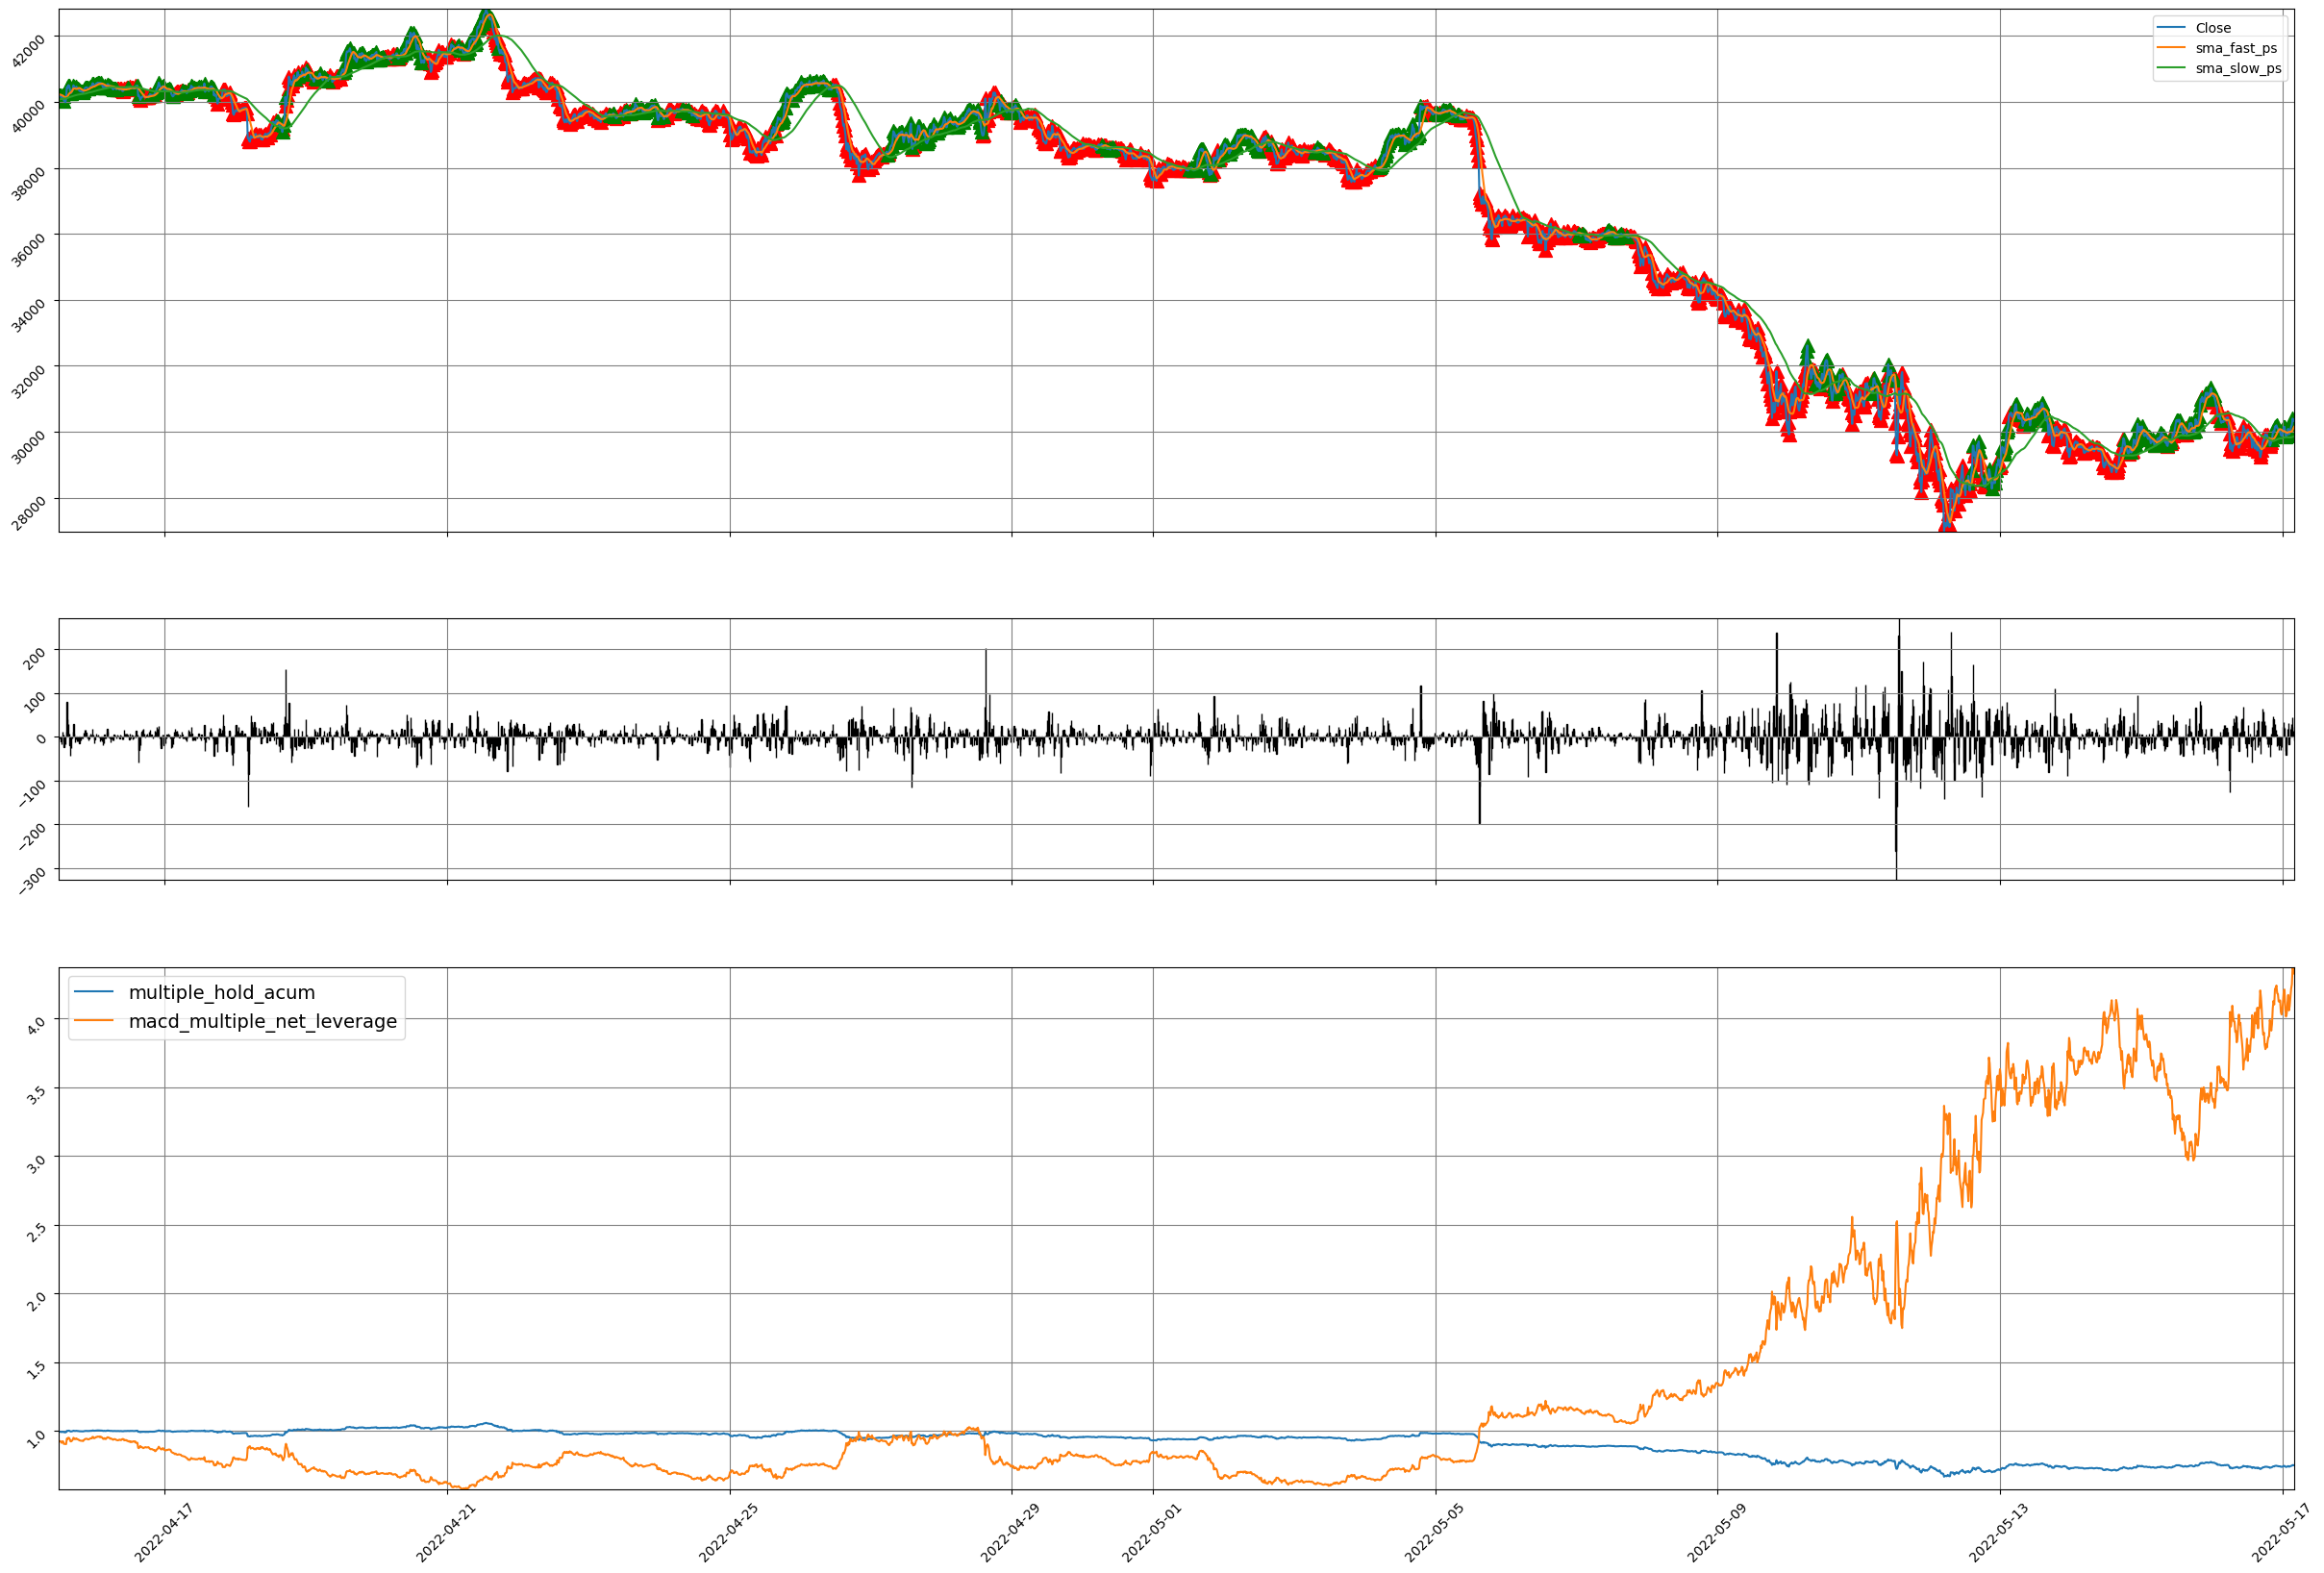

In [44]:
macd_ls_sma_sltp_lev_15m.plot_backtest_results(start_plot='2022-04-15-12:00', end_plot='2022-05-17-04:00', width_bars=0.003, leverage=True)

In [45]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [42]:
macd_ls_sma_sltp_lev_15m.data_init

Open      High       Low     Close        Volume  \
Date                                                                        
2022-04-14 15:00:00  40435.03  40483.66  40388.20  40426.32    435.334160   
2022-04-14 15:15:00  40426.33  40478.78  40345.49  40417.82    360.392300   
2022-04-14 15:30:00  40417.83  40430.20  39944.87  39978.15   1468.201650   
2022-04-14 15:45:00  39978.15  40037.48  39925.21  39964.02    965.503740   
2022-04-14 16:00:00  39964.01  40069.00  39855.75  39989.27   1038.588890   
2022-04-14 16:15:00  39989.26  40016.07  39891.84  39940.03    598.535690   
2022-04-14 16:30:00  39940.03  39978.97  39772.58  39864.69    877.580120   
2022-04-14 16:45:00  39864.70  39953.94  39783.15  39951.10    534.564390   
2022-04-14 17:00:00  39951.11  39975.37  39870.00  39879.65    298.796770   
2022-04-14 17:15:00  39879.64  39940.75  39854.81  39933.59    326.077760   
2022-04-14 17:30:00  39933.60  40060.05  39890.55  39890.56    396.640190   
2022-04-14 17:45:00  39890.55  39988.46  39842.00  39986.83    418.903120   
2022-04-14 18:00:00  39986.84  40028.94  39925.01  39958.77    366.995850   
2022-04-14 18:15:00  39958.77  39977.14  39850.74  39924.66    350.333790   
2022-04-14 18:30:00  39924.67  39957.63  39829.81  39891.95    269.206780   
2022-04-14 18:45:00  39891.94  39925.00  39626.06  39659.00    733.233840   
2022-04-14 19:00:00  39658.99  39781.82  39551.94  39732.88    672.759640   
2022-04-14 19:15:00  39732.89  39799.99  39697.60  39749.33    249.514540   
2022-04-14 19:30:00  39749.33  39793.32  39709.52  39780.00    260.652330   
2022-04-14 19:45:00  39780.00  39847.79  39735.29  39775.82    280.271000   
2022-04-14 20:00:00  39775.81  39815.05  39662.46  39702.37    508.775180   
2022-04-14 20:15:00  39702.38  39783.38  39670.00  39773.63    198.264800   
2022-04-14 20:30:00  39773.62  39894.94  39773.62  39843.49    226.632950   
2022-04-14 20:45:00  39843.50  39910.00  39798.27  39909.99    257.998440   
2022-04-14 21:00:00  39909.99  39936.70  39861.31  39862.47    242.889180   
2022-04-14 21:15:00  39862.48  39919.24  39862.47  39900.98    131.131160   
2022-04-14 21:30:00  39900.98  40000.00  39900.00  39900.00    153.027100   
2022-04-14 21:45:00  39900.01  39982.06  39889.60  39970.00    102.231970   
2022-04-14 22:00:00  39969.99  40017.26  39940.04  40006.36    189.393000   
2022-04-14 22:15:00  40006.36  40006.36  39950.00  39973.57    173.813750   
2022-04-14 22:30:00  39973.57  39980.79  39830.00  39884.07    277.131330   
2022-04-14 22:45:00  39884.06  39918.46  39806.25  39843.71    237.227230   
2022-04-14 23:00:00  39843.71  39919.66  39828.95  39906.51    129.128140   
2022-04-14 23:15:00  39906.50  39916.30  39853.25  39901.01     91.064520   
2022-04-14 23:30:00  39901.02  39946.94  39861.00  39938.55     97.285350   
2022-04-14 23:45:00  39938.55  39943.66  39890.00  39942.38     89.997720   
2022-04-15 00:00:00  39942.37  40004.08  39901.40  39957.96    266.124260   
2022-04-15 00:15:00  39957.96  40180.00  39933.61  40102.39    378.002040   
2022-04-15 00:30:00  40102.38  40104.36  39826.76  39860.00    338.669540   
2022-04-15 00:45:00  39859.99  39906.30  39766.40  39859.99    374.629770   
2022-04-15 01:00:00  39859.99  39932.17  39833.87  39895.73    403.253880   
2022-04-15 01:15:00  39895.72  39949.49  39889.59  39937.52    156.096510   
2022-04-15 01:30:00  39937.51  39978.66  39876.71  39973.37    170.965060   
2022-04-15 01:45:00  39973.38  39973.38  39933.00  39941.00    210.412420   
2022-04-15 02:00:00  39941.01  39963.58  39909.06  39946.27    101.051400   
2022-04-15 02:15:00  39946.28  40075.35  39926.58  40023.70    219.157290   
2022-04-15 02:30:00  40023.69  40060.00  39992.62  40030.09    123.589810   
2022-04-15 02:45:00  40030.09  40047.71  39978.00  40017.20    198.573390   
2022-04-15 03:00:00  40017.19  40115.07  40000.00  40091.36    212.472540   
2022-04-15 03:15:00  40091.37  40166.32  40050.00  40130.71    195.573100   
2022-04-15 03:30:00  

In [11]:
macd_ls_sma_sltp_lev_15m.sltp_dates

[(Timestamp('2022-04-14 18:45:00'),
  'sl=False',
  'tp=True',
  'short position finished'),
 (Timestamp('2022-04-14 19:00:00'),
  'sl=True',
  'tp=False',
  'short position finished'),
 (Timestamp('2022-04-14 20:15:00'),
  'sl=True',
  'tp=False',
  'short position finished'),
 (Timestamp('2022-04-14 23:30:00'),
  'sl=True',
  'tp=False',
  'short position finished'),
 (Timestamp('2022-04-15 01:15:00'),
  'sl=True',
  'tp=False',
  'short position finished'),
 (Timestamp('2022-04-15 02:15:00'),
  'sl=True',
  'tp=False',
  'short position finished'),
 (Timestamp('2022-04-15 03:45:00'),
  'sl=True',
  'tp=False',
  'short position finished'),
 (Timestamp('2022-04-15 04:30:00'),
  'sl=True',
  'tp=False',
  'long position finished'),
 (Timestamp('2022-04-15 06:15:00'),
  'sl=True',
  'tp=False',
  'long position finished'),
 (Timestamp('2022-04-15 08:00:00'),
  'sl=False',
  'tp=True',
  'long position finished'),
 (Timestamp('2022-04-15 09:15:00'),
  'sl=True',
  'tp=False',
  'long po